In [45]:
dt_file =  'data/dt/'
out_file = 'result/lgb/'

In [4]:
import pandas as pd
import numpy as np
import joblib
import copy
import warnings
warnings.filterwarnings('ignore')
import riskModel as rs
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 #字体大小
plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
%matplotlib inline
lgb.__version__

'3.1.0.99'

In [5]:
from ultraopt.hdl import layering_config,hdl2cs
from ultraopt import fmin
from ultraopt.multi_fidelity import HyperBandIterGenerator

In [6]:
# # 加载数据
# data = pd.read_excel(dt_file+'data_new.xlsx')
# data.sample(3)
data = pd.read_csv(dt_file+'data_dfs.csv')
data.sample(3)

,C_APP_ID,APP_CHANNEL,id_number,name,mobile,apply_date,LOAN_DATE,FINANCE_PRODUCT_CODE,TENOR,OVERDUE_DAYS,...,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数,br.按身份证号查询，近3个月在非银机构申请最大间隔天数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数,br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近12个月在非银机构-持牌消费金融机构申请机构数,br.按身份证号查询，近12个月最大月申请次数,br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数,br.按身份证号查询，近3个月申请线上小额现金贷的次数 / br.按手机号查询，近12个月申请线下消费分期的次数
3412,2478793508970500,MOGUJIE01,2a9d53f126978c3199d88950a81237d8,20a2bd2a8d03663b1f6351b981785aeb,3723abaa91948696e17b4f504b7bb2a1,2020-06-06,2020-06-06,PDL02,12,0,...,NaN,30.0,6.0,NaN,0.333333,1.500000,NaN,11.0,3.0,NaN
6727,2427176500658263,RONGSHU,e4d3f3a67d43fef5bc01e99f9c7ecaa7,a4c4ce500935b06c0ceafaecb799bcb5,092d4deb37be64bb33d3a1e526245a94,2020-03-25,2020-03-25,PDL02,12,0,...,NaN,NaN,NaN,14.0,NaN,0.933333,NaN,13.0,NaN,NaN
652,2461035618189400,RONGSHU,7f55e5c78f8f18ac3ce81527c4dc08a5,f71510964633938e29b223dda47cf4d3,dddee4be7541880fc98c20ee5ce2bf9d,2020-05-12,2020-05-12,PDL02,12,0,...,NaN,31.0,1.0,1.0,3.000000,1.000000,NaN,3.0,NaN,NaN


In [8]:
# 手动删除特征
self_drop = [
             'td.dqsh.身份证关联到的180天内P2P网贷行业下贷款事件中的不同平台个数 / td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数',
             'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近6个月在非银机构有申请记录月份数',
             'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数',
             'br.按手机号查询，近1个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月在非银机构-持牌网络小贷机构申请次数',
             'br.按手机号查询，近1个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数',
             'br.按身份证号查询，近6个月在非银机构-持牌小贷机构申请机构数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数',
             'zzc.D720.身份证号码.其他类.申请数',
             'br.按手机号查询，近12个月申请线上小额现金贷的机构数',
             'td.dqsh.身份证关联到的180天内非银行类金融行业下申贷事件中30日平台数的标准差',
             'br.按身份证号查询，近12个月在非银机构-持牌消费金融机构申请次数 / br.按手机号查询，近12个月申请线下消费分期的次数',
             'br.按手机号查询，近15天在非银机构-消费类分期机构申请次数 / br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数',
             'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数',
             'br.按手机号查询，近1个月在非银机构-持牌消费金融机构申请次数 / br.按手机号查询，近6个月申请线下现金分期的次数',
             'br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近12个月在非银机构-改制机构申请次数',
             'td.zrf.小额多期分标准版_',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'td.zrf.智融分2.0银行分标准版',
            'br.按身份证号查询，近12个月在非银机构平均每月申请次数(有申请月份平均) / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近12个月在非银机构-持牌消费金融机构申请机构数',
            'br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近3个月申请线上现金分期的次数',
            'br.按身份证号查询，近12个月在非银机构平均每月申请次数(有申请月份平均) / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月有申请记录月份数',
            'zzc.D360.身份证号码.非银行持牌类.申请数 / zzc.D720.手机号码.非银行持牌类.申请数',
            'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数',
            'zzc.D360.身份证号码.其他类.申请数',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近15天在非银机构周末申请机构数',
            'br.按手机号查询，近6个月申请线下现金分期的机构数 / br.按身份证号查询，近12个月有申请记录月份数',
            'td.dqsh.身份证关联到的90天内全行业下贷款事件中的不同平台个数',
            'br.线下消费贷客群评分',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'zzc.D360.身份证号码.非银行持牌类.申请数 / zzc.D720.手机号码.非银行持牌类.申请数',
            'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近6个月在非银机构有申请记录月份数',
            'zzc.D720.身份证号码.其他类.申请机构数',
            'br.按手机号查询，近15天在非银机构-消费类分期机构申请次数 / br.按身份证号查询，近12个月在非银机构周末申请次数',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数',
            ]

In [9]:
#------------------------手动删除特征--------------------
# 加载特征
with open(dt_file+'features_dfs.txt','r') as f:
    features = f.read().split('\n')
    
with open(dt_file+'cat_feature_new.txt','r') as f:
    cat_features = f.read().split('\n')

high_iv = joblib.load('./result/scorecard/high_iv.pkl')

features = [i for i in features if i not in self_drop and i+'_woe' in high_iv.keys()
           ]
cat_features = [i for i in cat_features if i not in self_drop and i in features]
print(len(features))
print(cat_features)

55
[]


In [10]:
# 极值处理,缺失处理
data = data.replace({float('inf'):-998,float('-inf'):-998})
# 缺失填充
pr = rs.Preprocess()
data = pr.fill_nan(df=data,cols=features,values=-999,min_miss_rate=0.05)

In [11]:
def prob2score(prob,basePoint=550,PDO=100,odds=30):
    # 将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    a = basePoint - y * np.log(odds)
    y2 = a - PDO/np.log(2)*(y)
    score = y2.astype('int')
    return score

In [12]:
# 数据集划分
# 分层抽样, 每个月随机抽取30%
# 随机抽样, 抽取 30%做验证
from datetime import datetime
from sklearn.model_selection import train_test_split

dt = copy.deepcopy(data)
dt = dt.loc[(dt['target'] != -999)&(dt['target']!=2),:]

sample_method = 1 # 1-按日分层, 2-按月分层, 3-按日期切, 4-全量样本 

test_size = 0.3 
if sample_method == 1:
    train,valid = train_test_split(dt,test_size=test_size,random_state=45,stratify=dt[['apply_date']])
elif sample_method == 2: 
    dt['mon'] = dt['apply_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d').month)
    train,valid = train_test_split(dt,test_size=test_size,random_state=45,stratify=dt[['mon','target']])
elif sample_method == 3:
    train = dt.loc[dt['apply_date'] <  datetime.strptime('20200501','%Y%m%d'),:]
    valid = dt.loc[dt['apply_date'] >= datetime.strptime('20200501','%Y%m%d'),:]
elif sample_method == 4:
    train = copy.deepcopy(dt)
    valid = copy.deepcopy(dt)
else: # 随机抽样
    train,valid = train_test_split(dt,test_size=test_size,random_state=45)
    
print('train size:',train.shape)
print('valid size:',valid.shape)
print('train:\n',train['target'].value_counts(normalize=False))
print('test:\n',valid['target'].value_counts(normalize=False))

train size: (9128, 145)
valid size: (3913, 145)
train:
 0    8028
1    1100
Name: target, dtype: int64
test:
 0    3452
1     461
Name: target, dtype: int64


In [13]:
# 样本分布
tmp = copy.deepcopy(data)
tmp['mon'] = tmp['apply_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d').month)
tmp.loc[tmp['target'] !=-999,'mon'].value_counts()

3    5660
5    3604
4    2723
6    1700
Name: mon, dtype: int64

###  ------------------------特征选择--------------------

In [12]:
# data['zzc.D90.身份证号码.贷款类型列表.consumerfinance'].value_counts(normalize=True)

#### 若将一个特征置为随机数，模型效果下降很多，说明该特征比较重要；反之则不是

In [14]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from typing import List

In [15]:
def Per_fit(clf,df:pd.DataFrame,features:List[str],target:str):
    X = df[features].fillna(-999)
    y = df[target]
    clf = clf.fit(X,y)
    perm = PermutationImportance(clf).fit(X,y)
    
    result_ = {'var':X.columns.values,'feature_importances_':perm.feature_importances_}
    
    feature_importances_ = pd.DataFrame(result_, columns=['var','feature_importances_'])
    feature_importances_ = feature_importances_.sort_values('feature_importances_',ascending=False)
    return feature_importances_

In [15]:
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(random_state=45)
feature_importances_1 = Per_fit(model_1,df=dt,features=features,target='target')

In [16]:
model_2 = lgb.LGBMClassifier(objective='binary',random_state=45)
feature_importances_2 = Per_fit(model_2,df=dt,features=features,target='target')

In [17]:
feature_importances_2.tail(5)

,var,feature_importances_
44,br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近12...,0.000905
10,br.按手机号查询，近12个月有申请记录月份数 / br.按手机号查询，近1个月在非银机构-...,0.000874
18,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近3个月在非银...,0.000874
25,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月申请...,0.000782
54,br.按身份证号查询，近3个月申请线上小额现金贷的次数 / br.按手机号查询，近12个月申...,0.000675


In [24]:
features_new = set(feature_importances_1.loc[feature_importances_1['feature_importances_']  > 0.0005,'var'])\
               &set(feature_importances_2.loc[feature_importances_2['feature_importances_'] > 0.002,'var'])

cat_features_new = list(set(cat_features)&features_new)
features_new = list(features_new)

print('cat_cols:\n',cat_features_new)
# 手动删除特征
self_drop = []
features_new = [f for f in features_new if f not in self_drop]
print('cols len:\n',len(features_new))
features_new

cat_cols:
 []
cols len:
 35


['br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数',
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数',
 'br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数',
 'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月在非银机构周末申请次数',
 'br.按手机号查询，近12个月有申请记录月份数 / br.按手机号查询，近1个月申请线上小额现金贷的次数',
 'mob.credit_score',
 'br.按身份证号查询，近3个月申请线上小额现金贷的次数 / br.按手机号查询，近12个月有申请记录月份数',
 'br.按身份证号查询，近6个月在非银机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数',
 'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数',
 'br.按身份证号查询，近6个月在非银机构申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数',
 'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数',
 'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按身份证号查询，近6个月在非银机构申请机构数',
 'br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数',
 'mob.wd_score_v2',
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数',
 'td.zrf.通用分标准版_',
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数',
 'br.信用风险识别-线上现金分期',
 'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数',
 'br.按手

###  ------------------------模型训练--------------------

In [18]:
self_col = [
    "mob.credit_score",
"mob.wd_score_v1",
"mob.wd_score_v2",
"td.zrf.智融分2.0通用分标准版",
"br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数",
"td.zrf.智融分2.0非银分标准版",
"YM_SCORE",
"td.zrf.通用分标准版_",
"br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数",
"br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数",
"br.信用风险识别-线上现金分期",
"br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数",
"td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数",
"br.按身份证号查询，近6个月在非银机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数",
"br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数",
"br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数",
"br.按手机号查询，近15天在非银机构申请次数",
"br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近12个月最大月申请次数",
"br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数",
"br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数",
"br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按身份证号查询，近6个月在非银机构申请机构数",
"br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数",
"br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近6个月在非银机构-持牌消费金融机构申请次数",
"br.按身份证号查询，近6个月在非银机构申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数",
"br.按手机号查询，近12个月在非银机构-现金类分期机构申请次数 / br.按手机号查询，近3个月申请线上小额现金贷的机构数",
"br.按手机号查询，近1个月申请线上小额现金贷的次数 / br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数",
"br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数",
"br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月有申请记录月份数",
"br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数",
"br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数",
"br.按手机号查询，近12个月在非银机构-现金类分期机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数",
"br.按手机号查询，近12个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数",
"br.按手机号查询，近12个月有申请记录月份数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数",
"br.按手机号查询，近12个月有申请记录月份数 / br.按手机号查询，近1个月申请线上小额现金贷的次数",
"br.按身份证号查询，近3个月申请线上小额现金贷的次数 / br.按手机号查询，近12个月有申请记录月份数",
"br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数",
"br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月在非银机构周末申请次数",
"br.按手机号查询，近3个月申请线上小额现金贷的机构数 / br.按手机号查询，近12个月在非银机构-现金类分期机构申请次数"]
len(self_col)
features_new = self_col
cat_features_new = []

In [19]:
#------------------------Build LightGBM data--------------------
params = {'feature_pre_filter':False}
serch_data = lgb.Dataset(data = dt[features_new],label=dt['target'],free_raw_data=False,
                       feature_name=features_new,categorical_feature=cat_features_new,params=params)

train_data=lgb.Dataset(data = train[features_new],label=train['target'],free_raw_data=False,
                       feature_name=features_new,categorical_feature=cat_features_new,params=params)

valid_data=lgb.Dataset(data = valid[features_new],label=valid['target'],free_raw_data=False,
                       feature_name=features,categorical_feature=cat_features_new,params=params)

In [20]:
# 定义参数搜索空间
HDL = {
    'boosting':{'_type':'choice','_value':['gbdt','dart'],'_default':'dart'},
    'num_leaves':{'_type':'int_quniform','_value':[5,127,1],'_default':15},
    'max_depth':{'_type':'int_quniform','_value':[3,9,1],'_default':3},
    'learning_rate':{'_type':'loguniform','_value':[0.01,0.1],'_default':0.05},
    'num_boost_round':{'_type':'int_quniform','_value':[50,1000,50],'_default':100},
    'min_data_in_leaf':{'_type':'int_quniform','_value':[10,300,10],'_default':20},
    'lambda_l1':{'_type':'quniform','_value':[0,1,0.01],'_default':0.001},
    'lambda_l2':{'_type':'quniform','_value':[0,1,0.01],'_default':0.001},
    'feature_fraction':{'_type':'quniform','_value':[0.5,1,0.1],'_default':1},
    'bagging_fraction':{'_type':'quniform','_value':[0.5,1,0.1],'_default':1},
    'min_child_weight':{'_type':'quniform','_value':[0.01,0.1,0.01],'_default':0.01},
    'is_unbalance':{'_type':'choice','_value':[False,True],'_default':True},
    'early_stopping_rounds':{'_type':'int_quniform','_value':[50,500,50],'_default':100},
    'random_state':45
}
CS = hdl2cs(HDL)

In [29]:
# CS.sample_configuration(1).get_dictionary()

In [30]:
# from collections import Counter
# configs = [config.get_dictionary() for config in CS.sample_configuration(1000)]
# variables = {key:[config[key] for config in configs] for key in HDL}
# boosting_cnt = Counter(variables['boosting'])
# is_unbalance_cnt = Counter(variables['is_unbalance'])

In [31]:
# plt.rcParams['figure.figsize'] = (20,10)

# # choice: boosting,is_unbalance
# plt.subplot(2,2,1)
# key = 'boosting'
# plt.title(key,c='black',size=15)
# plt.pie(list(boosting_cnt.values()),labels=list(boosting_cnt.keys()), autopct='%1.0f%%')

# # int_quniform: num_leaves,max_depth,num_boost_round,min_data_in_leaf,early_stopping_rounds
# plt.subplot(2,2,2)
# key = 'num_boost_round'
# plt.title(key,c='black',size=15)
# sns.distplot(variables[key],color='r',hist_kws={'alpha':0.3}, kde_kws={'linewidth':3})

# # loguniform: learning_rate
# plt.subplot(2,2,3)
# key = 'learning_rate'
# plt.title(key,c='black',size=15)
# sns.kdeplot(variables[key],color='g',linewidth=2,shade=True)

# # 等距离散分布
# # quniform: lambda_l1,lambda_l2,feature_fraction,bagging_fraction,min_child_weight
# plt.subplot(2,2,4)
# key = 'feature_fraction'
# plt.title(key,c='black',size=15)
# plt.hist(variables[key],color='m')

In [21]:
def add_default(param):
    # 添加固定参数
    parm_new = copy.deepcopy(param)
    parm_new['objective'] = 'binary'
    parm_new['num_threads'] = -1
#     parm_new['is_unbalance'] = True
    parm_new['tree_learner'] = 'feature' # 并行学习, feature,data,voting
    parm_new['metric'] = 'auc'
    parm_new['train_metric'] = True
    parm_new['verbose'] = -1
    return parm_new

In [22]:
# 评价函数
def evaluate(config: dict)->float:
    param = layering_config(config)
    param = add_default(param)
    cv_result = lgb.cv(params=param,
                       train_set=serch_data,
                       num_boost_round=param['num_boost_round'],
                       nfold = 3, 
                       metrics = 'auc',
                       early_stopping_rounds = param['early_stopping_rounds'],
                       eval_train_metric = True,
                       return_cvbooster = False,
                       feature_name = features_new,
                       show_stdv=False)
    train_auc = np.mean(cv_result['train auc-mean'])
    valid_auc = np.mean(cv_result['valid auc-mean'])
# #     最佳优化方案
#     loss_auc1 = train_auc - valid_auc
#     loss_auc2 = 0.75 - valid_auc
# #     select loss
#     if valid_auc < 0.65:
#         loss_auc = loss_auc2
#     else:
#         loss_auc = loss_auc1

    # 过拟合较为严重时优化方案
    loss_auc = train_auc - valid_auc
    # 效果较差时
#     loss_auc = 1 - valid_auc
    # print best auc 
    if loss_auc < 0.05:
        print(f'train_auc:{train_auc},valid_auc:{valid_auc},loss_auc:{loss_auc}\n')
        print(f'{param}\n')
    return loss_auc

In [23]:
# 优化方法, ETPE,Forest,GBRT,Random
result = fmin(eval_func=evaluate, config_space=HDL, optimizer='ETPE', n_iterations=20)
result

train_auc:0.7224212697418574,valid_auc:0.6868284201968649,loss_auc:0.03559284954499253

{'bagging_fraction': 0.7, 'boosting': 'dart', 'early_stopping_rounds': 300, 'feature_fraction': 1.0, 'is_unbalance': False, 'lambda_l1': 0.61, 'lambda_l2': 0.28, 'learning_rate': 0.016488831153310447, 'max_depth': 7, 'min_child_weight': 0.060000000000000005, 'min_data_in_leaf': 60, 'num_boost_round': 750, 'num_leaves': 6, 'random_state': 45, 'objective': 'binary', 'num_threads': -1, 'tree_learner': 'feature', 'metric': 'auc', 'train_metric': True, 'verbose': -1}

train_auc:0.7372164386303821,valid_auc:0.6930886343858436,loss_auc:0.04412780424453855

{'bagging_fraction': 0.6, 'boosting': 'dart', 'early_stopping_rounds': 50, 'feature_fraction': 0.6, 'is_unbalance': False, 'lambda_l1': 0.19, 'lambda_l2': 0.05, 'learning_rate': 0.01721644674011436, 'max_depth': 3, 'min_child_weight': 0.06999999999999999, 'min_data_in_leaf': 100, 'num_boost_round': 850, 'num_leaves': 84, 'random_state': 45, 'objective': 

+---------------------------------------+
| HyperParameters       | Optimal Value |
+-----------------------+---------------+
| bagging_fraction      | 0.5000        |
| boosting              | dart          |
| early_stopping_rounds | 350           |
| feature_fraction      | 0.6000        |
| is_unbalance          | False:bool    |
| lambda_l1             | 0.6300        |
| lambda_l2             | 0.2600        |
| learning_rate         | 0.0157        |
| max_depth             | 3             |
| min_child_weight      | 0.0200        |
| min_data_in_leaf      | 70            |
| num_boost_round       | 500           |
| num_leaves            | 5             |
| random_state          | 45:int        |
+-----------------------+---------------+
| Optimal Loss          | 0.0260        |
+-----------------------+---------------+
| Num Configs           | 20            |
+-----------------------+---------------+

In [ ]:
# 优化过程
# plt.figure(figsize = (12,7),dpi=100)
# result.plot_convergence()

In [104]:
# 优化过程
# result.plot_hi(target_name='loss', loss2target_func=lambda x:1-x)

In [24]:
def get_best_param(best_config:dict)->dict:
    # 获取最佳特征
    params = copy.deepcopy(best_config)
    params = add_default(params)
    params['is_unbalance'] = True if params['is_unbalance'].split(':')[0]=='True' else False
    try:
        del params['random_state']
    except:
        pass
    return params

In [25]:
best_param = get_best_param(result.best_config)
best_param

{'bagging_fraction': 0.5,
 'boosting': 'dart',
 'early_stopping_rounds': 350,
 'feature_fraction': 0.6,
 'is_unbalance': False,
 'lambda_l1': 0.63,
 'lambda_l2': 0.26,
 'learning_rate': 0.01567832763962577,
 'max_depth': 3,
 'min_child_weight': 0.02,
 'min_data_in_leaf': 70,
 'num_boost_round': 500,
 'num_leaves': 5,
 'objective': 'binary',
 'num_threads': -1,
 'tree_learner': 'feature',
 'metric': 'auc',
 'train_metric': True,
 'verbose': -1}

In [26]:
best_param = {'bagging_fraction': 0.5,
 'boosting': 'dart',
 'early_stopping_rounds': 350,
 'feature_fraction': 0.6,
 'is_unbalance': True,
 'lambda_l1': 0.63,
 'lambda_l2': 0.26,
 'learning_rate': 0.01567832763962577,
 'max_depth': 3,
 'min_child_weight': 0.02,
 'min_data_in_leaf': 70,
 'num_boost_round': 500,
 'num_leaves': 5,
 'objective': 'binary',
 'num_threads': -1,
 'tree_learner': 'feature',
 'metric': 'auc',
 'train_metric': True,
 'verbose': -1}

In [27]:
# 训练 model cv
cv_result = lgb.cv(params=best_param,
                   train_set=train_data,
                   num_boost_round=best_param['num_boost_round'],
                   nfold = 3, 
                   metrics = 'auc',
                   early_stopping_rounds = best_param['early_stopping_rounds'],
                   eval_train_metric = True,
                   return_cvbooster = True,
                   feature_name = features_new,
                   show_stdv=False)
# 指标
train_auc = np.mean(cv_result['train auc-mean'])
valid_auc = np.mean(cv_result['valid auc-mean'])
loss_auc = train_auc - valid_auc

print(f'train_auc:{train_auc},valid_auc:{valid_auc},loss_auc:{loss_auc}')

lgbm = cv_result['cvbooster']

train_auc:0.7400519701349049,valid_auc:0.6948813039837259,loss_auc:0.04517066615117893


In [28]:
# 输出模型重要度和IV
f_imp = {}
for i,col in enumerate(features_new):
    f_imp[col] = np.mean([lgbm.boosters[j].feature_importance()[i] for j in range(len(lgbm.boosters))])
f_imp = {t[0]:t[1] for t in sorted(f_imp.items(), key=lambda x:x[1],reverse=True)}
f_iv = {k:high_iv[k+'_woe'] for k in f_imp.keys()}
f_imp_iv = {'var':f_imp.keys(),'importance':f_imp.values(),'IV':f_iv.values()}
pd.DataFrame(f_imp_iv)#.to_excel(out_file+'feature_importance.xlsx',index=False)

,var,importance,IV
0,mob.credit_score,386.333333,0.311652
1,mob.wd_score_v1,316.666667,0.283450
2,mob.wd_score_v2,173.333333,0.298914
3,td.zrf.智融分2.0通用分标准版,170.666667,0.074841
4,br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询...,102.333333,0.049148
5,td.zrf.智融分2.0非银分标准版,92.333333,0.072270
6,YM_SCORE,79.000000,0.043304
7,br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询...,74.333333,0.031633
8,td.zrf.通用分标准版_,71.666667,0.030822
9,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非...,48.333333,0.030617


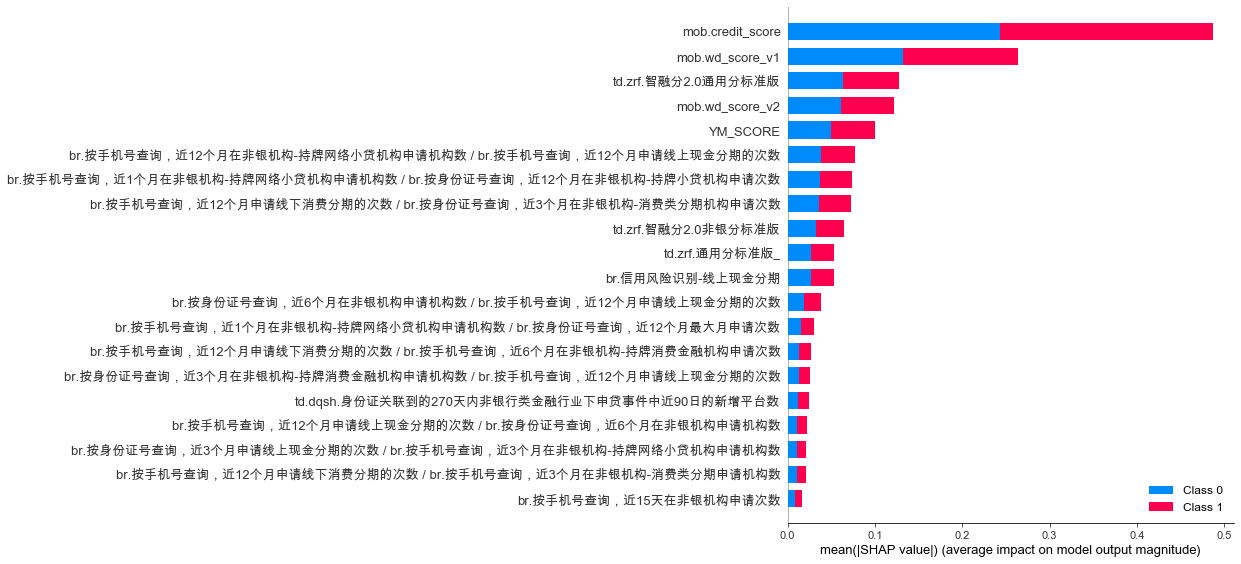

In [29]:
# 模型解释
import shap
shap.initjs()
explainer0 = shap.TreeExplainer(lgbm.boosters[0]) # cv 0,1,2
shap_values0 = explainer0.shap_values(valid[features_new])

explainer1 = shap.TreeExplainer(lgbm.boosters[1]) # cv 0,1,2
shap_values1 = explainer1.shap_values(valid[features_new])

explainer2 = shap.TreeExplainer(lgbm.boosters[2]) # cv 0,1,2
shap_values2 = explainer2.shap_values(valid[features_new])

shap_values = list(np.mean([shap_values0,shap_values1,shap_values2],axis=0))
shap.summary_plot(shap_values, valid[features_new])

In [121]:
# 单个特征对数据集的影响
# shap.dependence_plot('mob.credit_score', shap_values[0],valid[features_new])

In [122]:
# 可视化预测值
# shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], valid[features_new].iloc[2,:])

In [123]:
# 可视化多个预测值
# shap.force_plot(explainer.expected_value[1], shap_values[1][:5,:], valid[features_new].iloc[:5,:])

In [30]:
# 对全量样本打分
def prob2score(prob,basePoint=550,PDO=100,odds=30):
    # 将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    a = basePoint - y * np.log(odds)
    y2 = a - PDO/np.log(2)*(y)
    score = y2.astype('int')
    return score

prob_all = np.mean(lgbm.predict(data[features_new]),axis=0)
data['prob'] = prob_all
data['score'] = prob2score(prob_all)
print(data['score'].describe())

label_cols = ['C_APP_ID','APP_CHANNEL','id_number','name','mobile','apply_date','LOAN_DATE','FINANCE_PRODUCT_CODE',
             'TENOR','OVERDUE_DAYS','target_m2','target','balance_capital','curr_overdue','max_overdue','f6_max_overdue',
             'loan_amt','prob','score']

data[label_cols].to_excel(''.join([out_file,'data_score.xlsx']),index=False)

# 训练集苹果
train['prob'] = np.mean(lgbm.predict(train[features_new]),axis=0)
print(f'train:\n',rs.model_norm(train['target'],train['prob']))
# 验证集
valid['prob'] = np.mean(lgbm.predict(valid[features_new]),axis=0)
print(f'valid:\n',rs.model_norm(valid['target'],valid['prob']))
# 全集
dt_tmp = data.loc[(data['target'] != 2)&(data['target'] != -999),:]
print(f'data:\n',rs.model_norm(dt_tmp['target'],dt_tmp['prob']))

count    14910.000000
mean       579.106103
std         82.107322
min        360.000000
25%        528.000000
50%        586.000000
75%        638.000000
max        803.000000
Name: score, dtype: float64
train:
 {'AUC': 0.7408303890927209, 'KS': 0.341541423200616, 'cut_prob': 0.45708076433490114, 'recall': 0.7518181818181818, 'precision': 0.2003391472868217, 'accuracy': 0.6084574934268185, 'f1': 0.3163733741392502}
valid:
 {'AUC': 0.6899122266823847, 'KS': 0.29706190632988394, 'cut_prob': 0.5177583036733955, 'recall': 0.5509761388286334, 'precision': 0.22319859402460457, 'accuracy': 0.7211857909532328, 'f1': 0.31769856160100063}
data:
 {'AUC': 0.7258711359420723, 'KS': 0.3245937563475571, 'cut_prob': 0.5104048413852824, 'recall': 0.5912876361306855, 'precision': 0.2312124248496994, 'accuracy': 0.7157426577716433, 'f1': 0.3324329191428057}


In [51]:
data.loc[data['C_APP_ID']=='2424133964734507',self_col].to_dict(orient='index')

{290: {'mob.credit_score': 771,
  'mob.wd_score_v1': 759,
  'mob.wd_score_v2': 691,
  'td.zrf.智融分2.0通用分标准版': 494,
  'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数': 2.0,
  'td.zrf.智融分2.0非银分标准版': 746,
  'YM_SCORE': 791.0,
  'td.zrf.通用分标准版_': 723,
  'br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数': -999.0,
  'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数': -999.0,
  'br.信用风险识别-线上现金分期': 714.0,
  'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数': 0.125,
  'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数': 1.0,
  'br.按身份证号查询，近6个月在非银机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数': 8.0,
  'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数': 1.0,
  'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数': 0.5,
  'br.按手机号查询，近15天在非银机构申请次数': -999.0,
  'br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近12个月最大月申请次数': -999.0,
  'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数': -999.0,
  'br.按身份证号查询，近3个月申请线上现金分期的次数 / 

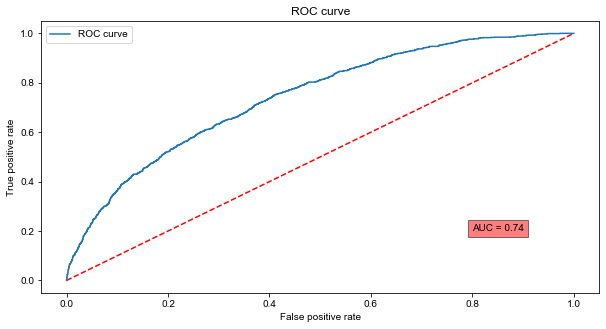

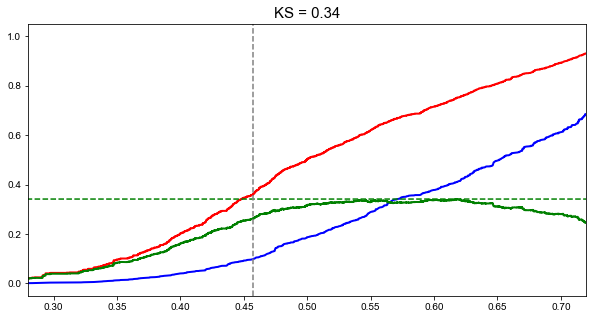

'KS = 0.34'

In [35]:
# 作图
plm = PlotModel(train['target'],train['prob'])
plm.plot_roc_curve(filename=out_file)
plm.plot_ks_curve(filename=out_file)

In [44]:
# 保存模型和模型变量
import joblib
joblib.dump(lgbm.boosters, ''.join([out_file,'geexCreditModel.pkl']))
    
with open(''.join([out_file,'features.txt']),'w') as f:
    f.write('\n'.join(features_new))
    
with open(''.join([out_file,'cat_features.txt']),'w') as f:
    f.write('\n'.join(cat_features_new))

In [33]:
# 保存txt模型
for i,m in enumerate(lgbm.boosters):
    m.save_model(f'{out_file}geexCreditModel_{str(i)}.txt')

In [34]:
from sklearn.metrics import roc_curve,auc

def best_prob(y_true,y_prob):
    """
    cut best prob
    :param y_prob: y of prediction
    :param y_true: real y
    :return: ks_value and draw ks
    """
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    max_ks = 0
    cut_prob = 0.5
    for i in range(len(thr)):
        if abs(fpr[i] - tpr[i]) > max_ks:
            max_ks = abs(fpr[i] - tpr[i])
            cut_prob = thr[i]
    return cut_prob

class PlotModel(object):
    """模型作图"""
    def __init__(self,y_true,y_prob):
        """
        :param y_true:array, 真实y
        :param y_prob: array, 预测概率y
        """
        self.y_true = y_true
        self.y_prob = y_prob

    def plot_roc_curve(self,filename='./'):
        """
        """
        plt.figure(figsize=(10,5))
        fpr, tpr, _ = roc_curve(self.y_true, self.y_prob)
        c_stats = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.plot(fpr, tpr, label="ROC curve")
        auc_value = "AUC = %.2f" % c_stats
        plt.text(0.8, 0.2, auc_value, bbox=dict(facecolor='r', alpha=0.5))
        plt.xlabel('False positive rate')  # 假正率
        plt.ylabel('True positive rate')  # 真正率
        plt.title('ROC curve')  # ROC 曲线
        plt.legend(loc='best')
        plt.savefig(filename+"roc_curve.png")
        plt.show()
        plt.close()
        return auc_value

    def plot_ks_curve(self,filename='./'):
        """
        """
        plt.figure(figsize=(10,5))
        fpr, tpr, thr = roc_curve(self.y_true, self.y_prob)  # 假正率 真正率 概率阈值
        thr = np.array(sorted(thr))
        ks = abs(fpr - tpr)  # ks 序列
        ks_value = "KS = %.2f" % max(ks)  # ks值
        cut_prob = best_prob(self.y_true, self.y_prob)  # 最佳切分概率
        plt.plot(thr, fpr, label='cum_good', color='blue', linestyle='-', linewidth=2)  # 假正率 累计好
        plt.plot(thr, tpr, label='cum_bad', color='red', linestyle='-', linewidth=2)  # 真正率,累计坏
        plt.plot(thr, ks, label='ks', color='green', linestyle='-', linewidth=2)  # ks曲线
        plt.plot(thr, [max(ks)] * len(thr), color='green', linestyle='--')  # ks值直线
        plt.axvline(cut_prob, color='gray', linestyle='--')  # 最佳切分概率直线
        plt.title('{}'.format(ks_value), fontsize=15)
        plt.xlim((0.28, 0.72))
        plt.savefig(filename+"ks_curve.png")  # 保存
        plt.show()
        plt.close()
        return ks_value